# Etude de la croissance économmique et démographique en France

In [1]:
# importation des librairies

import warnings
import itertools
import numpy as np
import statsmodels
import pandas as pd
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from tabulate import tabulate
from scipy.stats import kstest
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_excel("Copie de data_base.xlsx")

df.head(5)

,Année,PIB habitant %,Population_growth,Taux_Inflation,Tax _% PIB,M,X,Taux_mortalite_infantile,IDE,Solde_Migratoire,Taux_emploi,Taux_epargne,IDH,FBCF_annuel%,NB_naissance,NB_deces,Phase_economique,Periode_politique
0,1960,NaN,1.034469,NaN,NaN,12.582126,15.354800,23.7,NaN,143032,NaN,NaN,NaN,NaN,NaN,NaN,Croissance,Charles de Gaulle\n
1,1961,3.725257,1.004280,3.218333,NaN,12.485239,14.956307,22.4,NaN,128618,NaN,NaN,NaN,11.667663,NaN,NaN,Croissance,Charles de Gaulle\n
2,1962,5.803779,1.003536,4.889890,NaN,12.150719,13.653082,21.4,NaN,141634,NaN,NaN,NaN,6.693463,NaN,NaN,Croissance,Charles de Gaulle\n
3,1963,5.138223,1.066209,5.565798,NaN,12.425299,13.389768,20.4,NaN,190925,NaN,NaN,NaN,8.740709,NaN,NaN,Croissance,Charles de Gaulle\n
4,1964,5.297171,0.959388,4.171210,NaN,13.096584,13.545462,19.4,NaN,163039,NaN,NaN,NaN,9.961181,NaN,NaN,Croissance,Charles de Gaulle\n


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Année                     64 non-null     int64  
 1   PIB habitant %            63 non-null     float64
 2   Population_growth         64 non-null     float64
 3   Taux_Inflation            63 non-null     float64
 4   Tax _% PIB                51 non-null     float64
 5   M                         64 non-null     float64
 6   X                         64 non-null     float64
 7   Taux_mortalite_infantile  63 non-null     float64
 8   IDE                       49 non-null     float64
 9   Solde_Migratoire          64 non-null     int64  
 10  Taux_emploi               49 non-null     float64
 11  Taux_epargne              45 non-null     float64
 12  IDH                       33 non-null     float64
 13  FBCF_annuel%              63 non-null     float64
 14  NB_naissance

In [4]:
# On renomme les variables pour plus de clarté dans la base de données

nom = {
    "PIB habitant %" :"PIB_habitant",
    "Population_growth" : "Croissance_demo",
    "Taux_Inflation" : "Inflation",
    "Tax _% PIB" : "Taxe",
    "M" :"Importation",
    "X" :"Exportation",
    "Taux_mortalite_infantile" :"Mortalite_infantile",
    "FBCF_annuel%":"FBCF"
    }

df.rename(columns=nom, inplace=True)
display(df.tail(10))

,Année,PIB_habitant,Croissance_demo,Inflation,Taxe,Importation,Exportation,Mortalite_infantile,IDE,Solde_Migratoire,Taux_emploi,Taux_epargne,IDH,FBCF,NB_naissance,NB_deces,Phase_economique,Periode_politique
54,2014,0.519384,0.355569,0.570795,23.118742,31.457454,30.741813,3.1,5.655038e+10,52342,64.5,14.6,0.892,-0.396403,818565.0,559293.0,Croissance,François Hollande
55,2015,0.708031,0.263869,1.134440,23.166423,31.811192,31.693495,3.2,3.613089e+10,-345,64.7,14.1,0.893,0.618788,798948.0,593680.0,Croissance,François Hollande
56,2016,0.594244,0.290202,0.517258,23.088698,31.844546,31.498210,3.3,3.719800e+10,15548,65.0,13.9,0.896,2.758919,783640.0,593865.0,Croissance,François Hollande
57,2017,1.787795,0.358495,0.586343,23.686679,33.084014,32.311834,3.3,4.974373e+09,102984,65.6,14.1,0.899,3.698314,769553.0,606274.0,Croissance,Emmanuel Macron
58,2018,1.282166,0.332559,1.114593,24.252357,33.884279,32.917982,3.3,6.241764e+10,132925,66.1,14.4,0.903,3.502211,758590.0,609648.0,Croissance,Emmanuel Macron
59,2019,1.688708,0.324558,1.210523,24.569375,33.539418,32.889559,3.3,3.118469e+10,71972,66.4,15.0,0.905,4.110082,753383.0,613243.0,Croissance,Emmanuel Macron
60,2020,-7.740568,0.356902,2.977979,24.654612,30.281668,28.557223,3.3,9.367666e+09,145593,66.1,NaN,0.900,-5.829109,735196.0,668922.0,Crise,Emmanuel Macron
61,2021,6.501552,0.326992,1.221816,23.906122,32.500433,31.288050,3.3,2.020223e+10,131465,67.3,NaN,0.906,9.734361,742052.0,661585.0,Reprise,Emmanuel Macron
62,2022,2.235989,0.326319,3.220632,24.468609,39.286475,36.503669,3.3,-2.113566e+10,179377,68.2,NaN,0.910,-0.047778,725997.0,675122.0,Reprise,Emmanuel Macron
63,2023,0.607649,0.351892,5.303572,NaN,36.279524,34.280031,NaN,3.051310e+10,91862,68.4,NaN,NaN,0.389681,677803.0,639269.0,Crise,Emmanuel Macron


# TRAITEMENT DES VALEURS MANQUANTES



## Pour le traitement des nos données manquantes nous avons le choix entre plusieurs méthodes différentes.

- Imputattion par la moyenne, la médiande....
- Imputation avec les K plus proche voisin(KNN imputer) et d'autres algorithme

In [5]:

valeurs_manquantes = df.isna().sum()
taux_valeurs_manquantes = round(((valeurs_manquantes / len(df)) * 100),3)
tableau_valeurs_manquantes = pd.DataFrame({"Total valeurs manquantes": valeurs_manquantes,
                                        "Taux de valeurs manquantes % ": taux_valeurs_manquantes})
display(tableau_valeurs_manquantes)

# Il est judicieux de supprimer toutes les variables qui ont plus de 30% de valeurs manquantes.
# Vu la taille de de notre base une imputation de ces valeurs manquantes serait source de d'énorme biais.

,Total valeurs manquantes,Taux de valeurs manquantes %
Année,0,0.000
PIB_habitant,1,1.562
Croissance_demo,0,0.000
Inflation,1,1.562
Taxe,13,20.312
Importation,0,0.000
Exportation,0,0.000
Mortalite_infantile,1,1.562
IDE,15,23.438
Solde_Migratoire,0,0.000


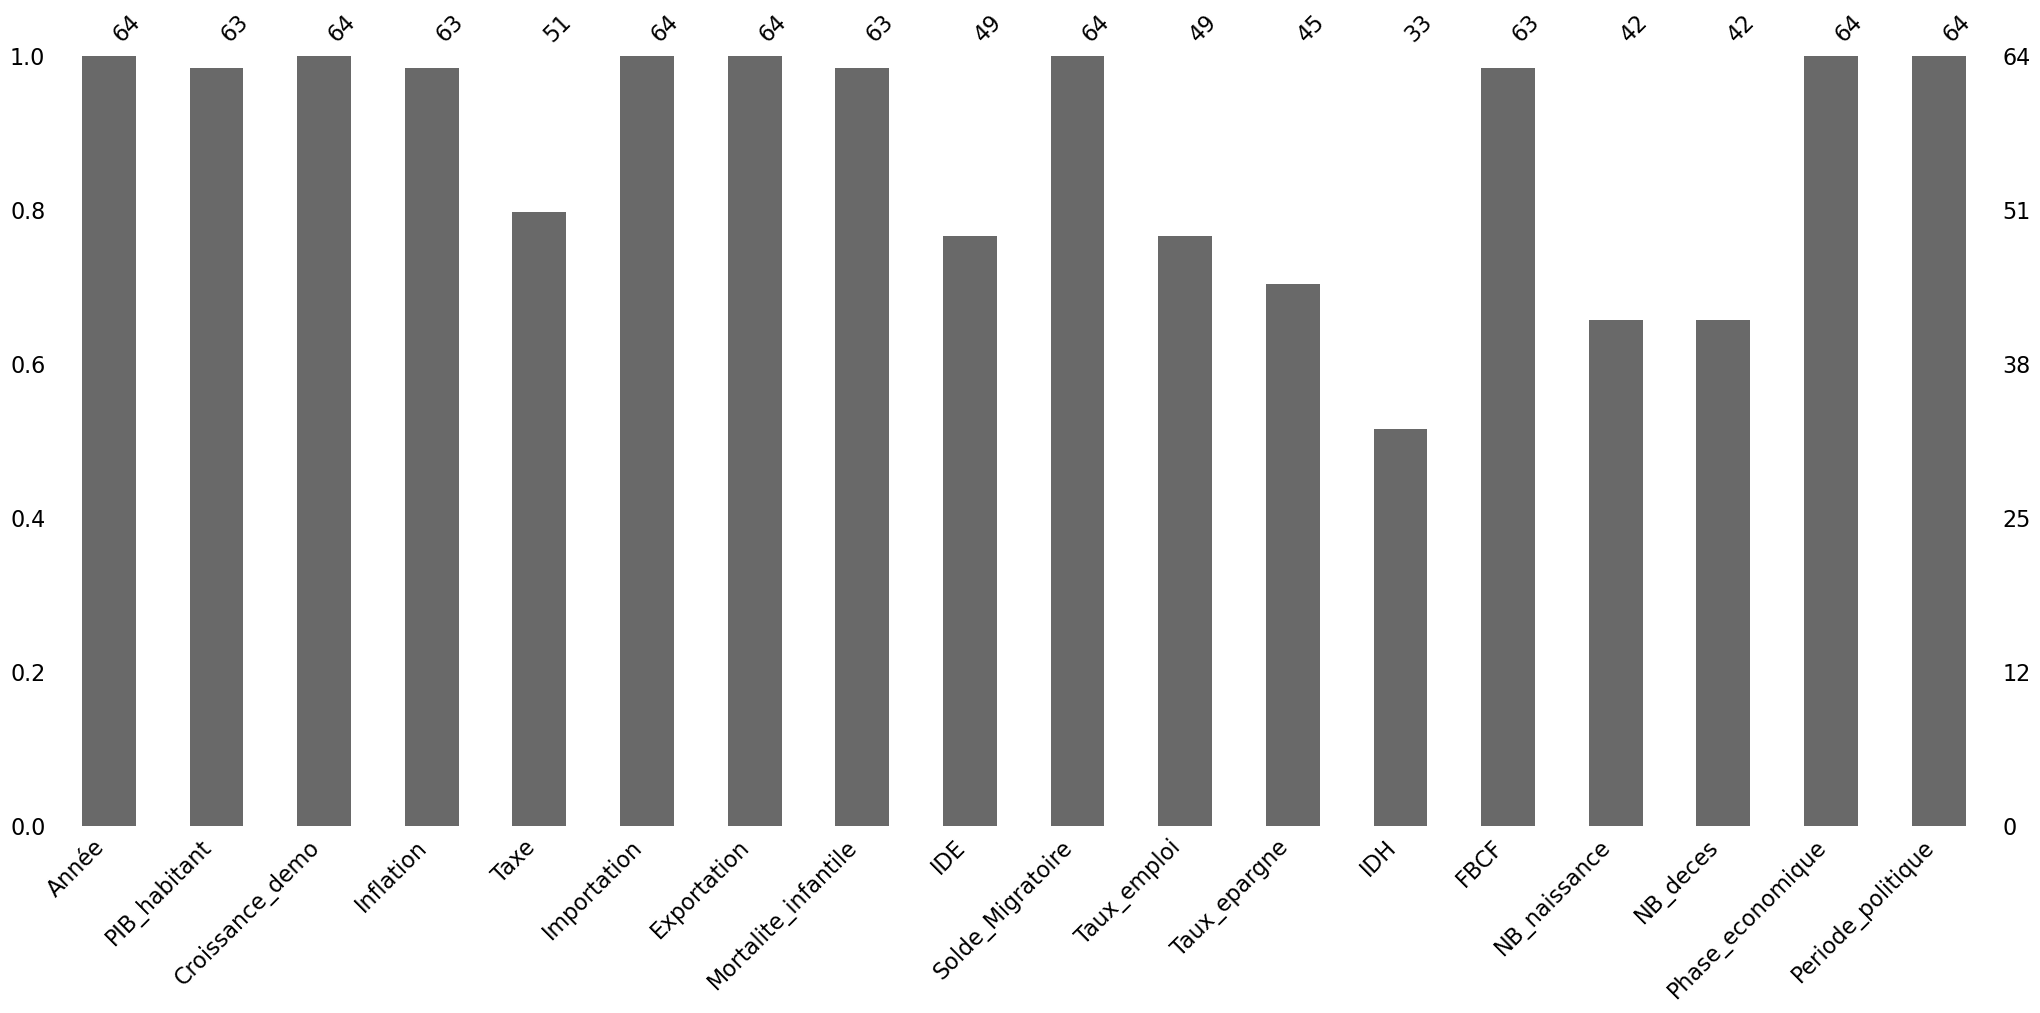

In [6]:
# Diagramme en bar pour avoir une vue sur les variable manquantes

msno.bar(df)
plt.show()

In [7]:
df.shape

(64, 18)

In [8]:
tableau_valeurs_manquantes[tableau_valeurs_manquantes.iloc[:,1]<30]

,Total valeurs manquantes,Taux de valeurs manquantes %
Année,0,0.000
PIB_habitant,1,1.562
Croissance_demo,0,0.000
Inflation,1,1.562
Taxe,13,20.312
Importation,0,0.000
Exportation,0,0.000
Mortalite_infantile,1,1.562
IDE,15,23.438
Solde_Migratoire,0,0.000


In [9]:
# plusieurs de nos variables contiennent des valeurs manquantes
# On suprimme les variables dont le taux de données manquantes est supérieur à 30%

a = tableau_valeurs_manquantes[tableau_valeurs_manquantes.iloc[:,1]<30].index
df = df[a]
display(df.head(5))

,Année,PIB_habitant,Croissance_demo,Inflation,Taxe,Importation,Exportation,Mortalite_infantile,IDE,Solde_Migratoire,Taux_emploi,Taux_epargne,FBCF,Phase_economique,Periode_politique
0,1960,NaN,1.034469,NaN,NaN,12.582126,15.354800,23.7,NaN,143032,NaN,NaN,NaN,Croissance,Charles de Gaulle\n
1,1961,3.725257,1.004280,3.218333,NaN,12.485239,14.956307,22.4,NaN,128618,NaN,NaN,11.667663,Croissance,Charles de Gaulle\n
2,1962,5.803779,1.003536,4.889890,NaN,12.150719,13.653082,21.4,NaN,141634,NaN,NaN,6.693463,Croissance,Charles de Gaulle\n
3,1963,5.138223,1.066209,5.565798,NaN,12.425299,13.389768,20.4,NaN,190925,NaN,NaN,8.740709,Croissance,Charles de Gaulle\n
4,1964,5.297171,0.959388,4.171210,NaN,13.096584,13.545462,19.4,NaN,163039,NaN,NaN,9.961181,Croissance,Charles de Gaulle\n


In [10]:
# trois variables dont le taux de valeurs manquantes est supérieur à 30% ont été supprimés de notre base
df.shape

(64, 15)

In [11]:
# maintenant on traite les données manquantes de notre base
# On choisit de faire une imputation par l'algorithme(KNNImputer de scikit-learn) des K plus proche voisins

imputer = KNNImputer(n_neighbors=5) # on prend les 5 plus proches voisins

var_manquante = tableau_valeurs_manquantes[(tableau_valeurs_manquantes.iloc[:,1] > 0) & (tableau_valeurs_manquantes.iloc[:,1] < 30)].index
df[var_manquante] = df[var_manquante].apply(pd.to_numeric, errors='coerce')

df[var_manquante] = imputer.fit_transform(df[var_manquante])

display(df.tail(5))

,Année,PIB_habitant,Croissance_demo,Inflation,Taxe,Importation,Exportation,Mortalite_infantile,IDE,Solde_Migratoire,Taux_emploi,Taux_epargne,FBCF,Phase_economique,Periode_politique
59,2019,1.688708,0.324558,1.210523,24.569375,33.539418,32.889559,3.30,3.118469e+10,71972,66.4,15.00,4.110082,Croissance,Emmanuel Macron
60,2020,-7.740568,0.356902,2.977979,24.654612,30.281668,28.557223,3.30,9.367666e+09,145593,66.1,13.38,-5.829109,Crise,Emmanuel Macron
61,2021,6.501552,0.326992,1.221816,23.906122,32.500433,31.288050,3.30,2.020223e+10,131465,67.3,14.46,9.734361,Reprise,Emmanuel Macron
62,2022,2.235989,0.326319,3.220632,24.468609,39.286475,36.503669,3.30,-2.113566e+10,179377,68.2,17.24,-0.047778,Reprise,Emmanuel Macron
63,2023,0.607649,0.351892,5.303572,20.557075,36.279524,34.280031,14.52,3.051310e+10,91862,68.4,14.68,0.389681,Crise,Emmanuel Macron


In [12]:
valeurs_manquantes = df.isna().sum()
taux_valeurs_manquantes = round(((valeurs_manquantes / len(df)) * 100),3)
tableau_valeurs_manquantes = pd.DataFrame({"Total valeurs manquantes": valeurs_manquantes,
                                        "Taux de valeurs manquantes % ": taux_valeurs_manquantes})
display(tableau_valeurs_manquantes)

,Total valeurs manquantes,Taux de valeurs manquantes %
Année,0,0.0
PIB_habitant,0,0.0
Croissance_demo,0,0.0
Inflation,0,0.0
Taxe,0,0.0
Importation,0,0.0
Exportation,0,0.0
Mortalite_infantile,0,0.0
IDE,0,0.0
Solde_Migratoire,0,0.0


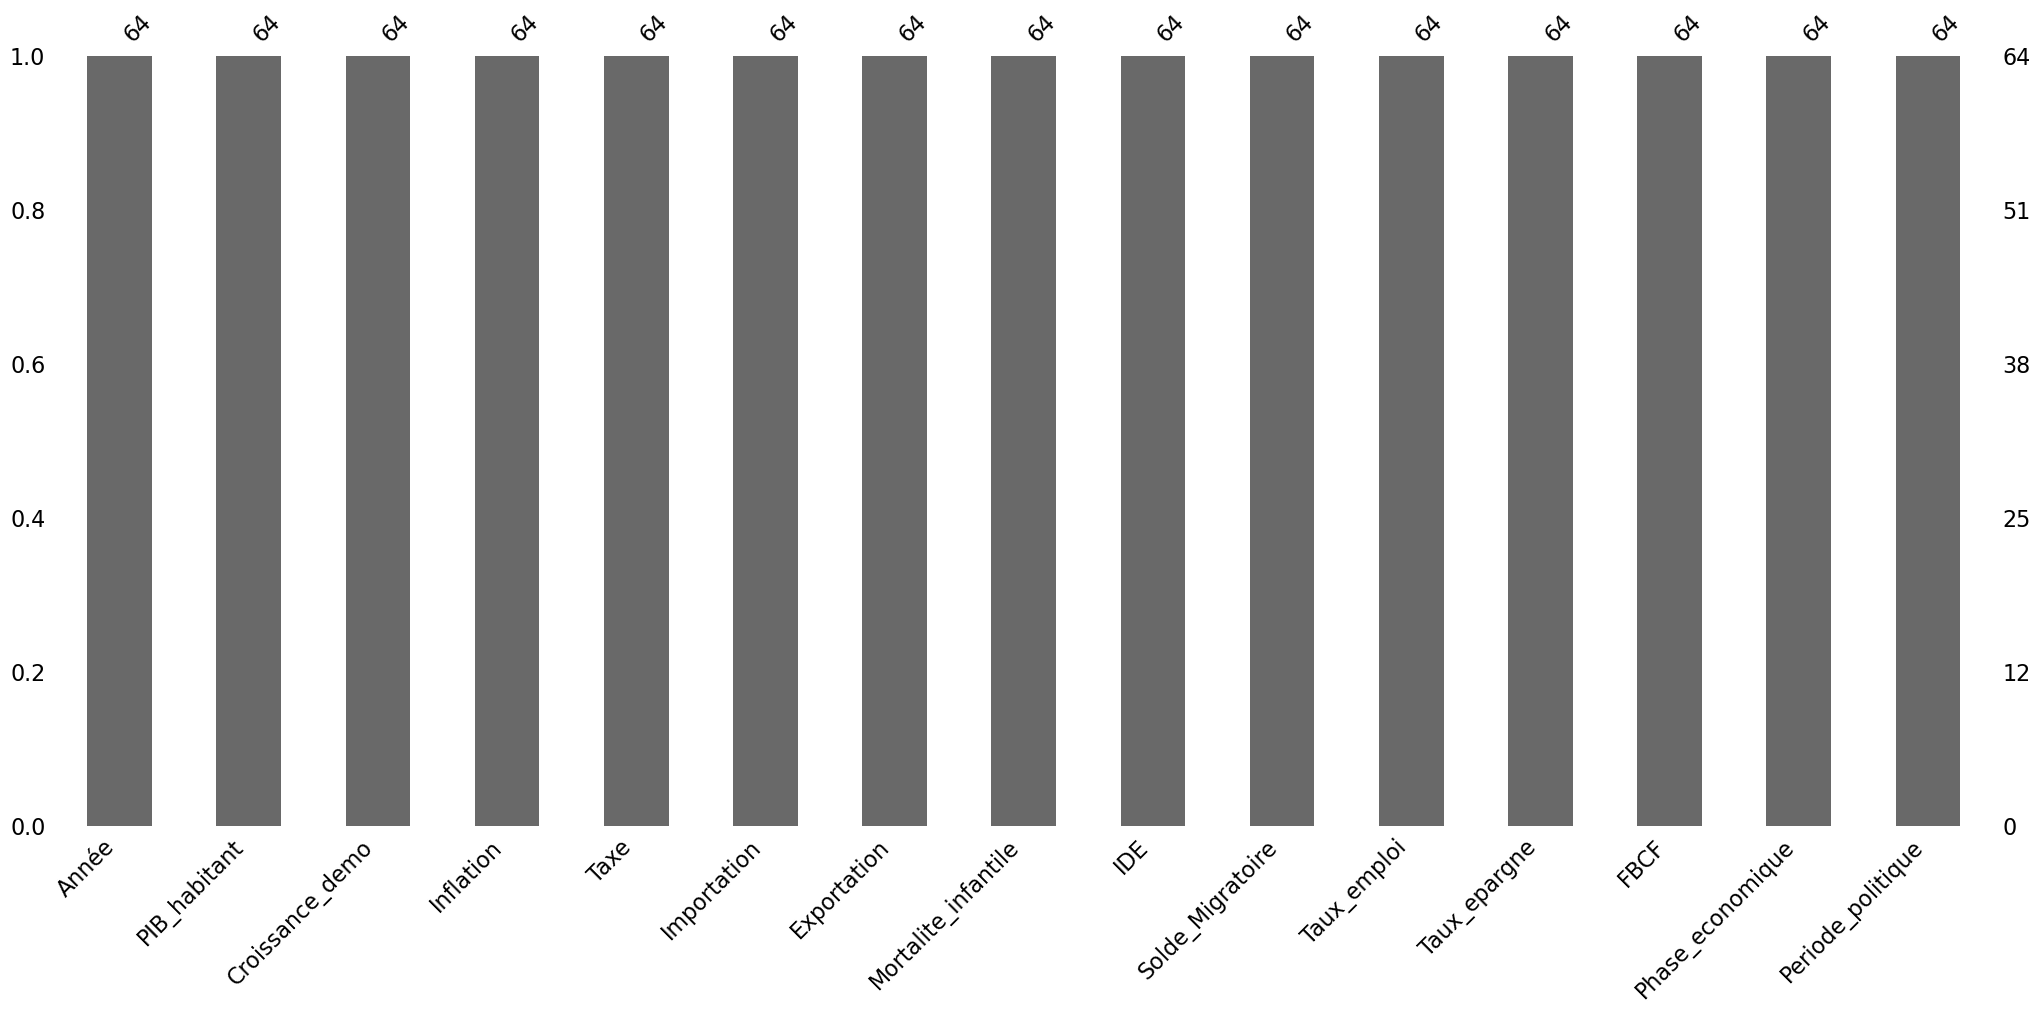

In [13]:
# Diagramme en bar pour avoir une vue sur les variable manquantes

msno.bar(df)
plt.show()

In [14]:
df.head(8)

,Année,PIB_habitant,Croissance_demo,Inflation,Taxe,Importation,Exportation,Mortalite_infantile,IDE,Solde_Migratoire,Taux_emploi,Taux_epargne,FBCF,Phase_economique,Periode_politique
0,1960,2.184687,1.034469,2.707959,22.281556,12.582126,15.354800,23.7,4.729000e+10,143032,63.16,14.4,4.749147,Croissance,Charles de Gaulle\n
1,1961,3.725257,1.004280,3.218333,22.281556,12.485239,14.956307,22.4,4.813693e+10,128618,64.62,14.4,11.667663,Croissance,Charles de Gaulle\n
2,1962,5.803779,1.003536,4.889890,22.281556,12.150719,13.653082,21.4,4.813693e+10,141634,64.62,14.4,6.693463,Croissance,Charles de Gaulle\n
3,1963,5.138223,1.066209,5.565798,22.281556,12.425299,13.389768,20.4,4.813693e+10,190925,64.62,14.4,8.740709,Croissance,Charles de Gaulle\n
4,1964,5.297171,0.959388,4.171210,22.281556,13.096584,13.545462,19.4,4.813693e+10,163039,64.62,14.4,9.961181,Croissance,Charles de Gaulle\n
5,1965,3.807211,0.866189,3.042572,22.281556,12.550052,14.010851,18.6,4.813693e+10,82879,64.62,14.4,5.632363,Croissance,Charles de Gaulle\n
6,1966,4.302799,0.813893,2.995828,22.281556,13.152674,14.008375,17.8,4.813693e+10,96097,64.62,14.4,7.883228,Croissance,Charles de Gaulle\n
7,1967,4.046078,0.766314,3.053965,22.281556,13.227213,13.863684,17.2,4.813693e+10,63018,64.62,14.4,7.875145,Croissance,Charles de Gaulle\n


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Année                64 non-null     int64  
 1   PIB_habitant         64 non-null     float64
 2   Croissance_demo      64 non-null     float64
 3   Inflation            64 non-null     float64
 4   Taxe                 64 non-null     float64
 5   Importation          64 non-null     float64
 6   Exportation          64 non-null     float64
 7   Mortalite_infantile  64 non-null     float64
 8   IDE                  64 non-null     float64
 9   Solde_Migratoire     64 non-null     int64  
 10  Taux_emploi          64 non-null     float64
 11  Taux_epargne         64 non-null     float64
 12  FBCF                 64 non-null     float64
 13  Phase_economique     64 non-null     object 
 14  Periode_politique    64 non-null     object 
dtypes: float64(11), int64(2), object(2)
memory

# PARTIE 1 :  ANALYSE DE DONNES EXPLORATOIRE
- Analyse & statistique descriptive
- Analyse graphique

In [16]:
round(df.iloc[:,1:].describe(), 3)

,PIB_habitant,Croissance_demo,Inflation,Taxe,Importation,Exportation,Mortalite_infantile,IDE,Solde_Migratoire,Taux_emploi,Taux_epargne,FBCF
count,64.000,64.000,64.000,64.000,64.000,64.000,64.000,6.400000e+01,64.000,64.000,64.000,64.000
mean,2.101,0.576,4.001,21.309,23.504,23.859,8.663,2.694549e+10,90021.578,64.281,14.773,2.891
std,2.293,0.211,3.543,1.912,6.758,6.114,5.866,2.715427e+10,60102.700,1.754,1.870,4.173
min,-7.741,0.264,0.106,17.923,12.151,13.390,3.100,-2.113566e+10,-21463.000,60.900,11.100,-9.229
25%,0.941,0.412,1.219,19.521,19.891,20.503,3.300,2.130251e+09,52167.000,62.970,14.100,0.152
50%,1.999,0.515,2.687,22.196,23.227,23.243,7.300,2.095887e+10,81568.000,64.590,14.400,2.862
75%,3.671,0.728,5.520,22.553,28.806,28.876,12.400,4.813693e+10,135102.250,64.850,14.850,5.913
max,6.502,1.066,13.638,24.655,39.286,36.504,23.700,1.322071e+11,200629.000,68.400,21.300,11.668


In [17]:
# On calcule les taux de croissance annuel et moyen de certaines variables

variable =['PIB_habitant', 'Croissance_demo', 'Inflation','FBCF']

n = len(df)
for i in variable :
  variable_decimale = df[i] / 100

  coefficient_multiplicateur = (1 + variable_decimale).prod()
  taux_global_pourcentage = (coefficient_multiplicateur - 1)*100

  TCAM = (coefficient_multiplicateur**(1/n)-1)*100
  print(f"Taux de croissance annuel moyen : {i} = {TCAM:.2f}%")
  print(f"Taux de croissance global : {i} = {taux_global_pourcentage:.2f}%\n")

Taux de croissance annuel moyen : PIB_habitant = 2.08%
Taux de croissance global : PIB_habitant = 272.41%

Taux de croissance annuel moyen : Croissance_demo = 0.58%
Taux de croissance global : Croissance_demo = 44.36%

Taux de croissance annuel moyen : Inflation = 3.94%
Taux de croissance global : Inflation = 1088.15%

Taux de croissance annuel moyen : FBCF = 2.81%
Taux de croissance global : FBCF = 487.95%



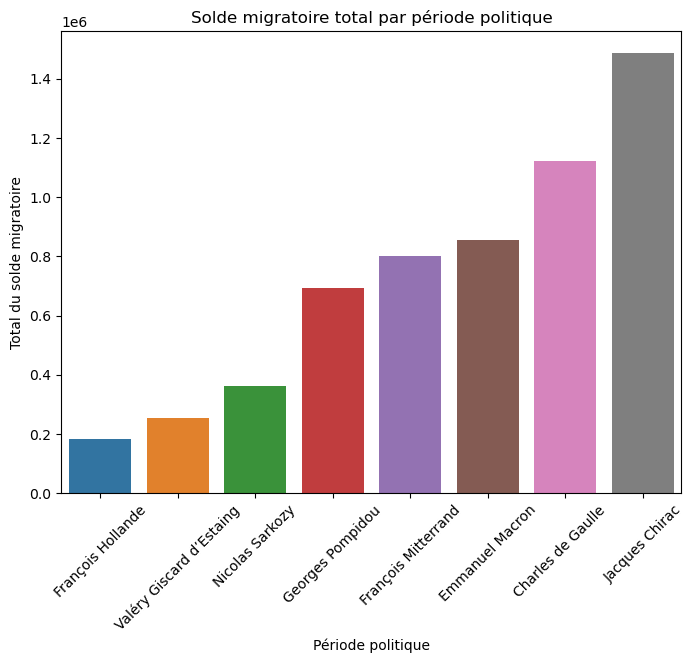

In [18]:
tableau_recap = df.groupby("Periode_politique")["Solde_Migratoire"].agg(
    Total=("sum"), Annee_gouvernance =("count")).reset_index()

tableau_recap = tableau_recap.sort_values(by="Total", ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x="Periode_politique",  y="Total", data=tableau_recap)

plt.title("Solde migratoire total par période politique")
plt.xlabel("Période politique")
plt.ylabel("Total du solde migratoire")
plt.xticks(rotation=45)
plt.show()

In [19]:
df_grand = pd.DataFrame({'Année': df["Année"],'Solde_Migratoire': df['Solde_Migratoire'],
    'IDE': df['IDE'] / 1000000 }) # Division IDE par 1 million pour une question d'échelle
display(df_grand.tail(5))

,Année,Solde_Migratoire,IDE
59,2019,71972,31184.687761
60,2020,145593,9367.666366
61,2021,131465,20202.234021
62,2022,179377,-21135.660318
63,2023,91862,30513.104656


<Axes: xlabel='Année'>

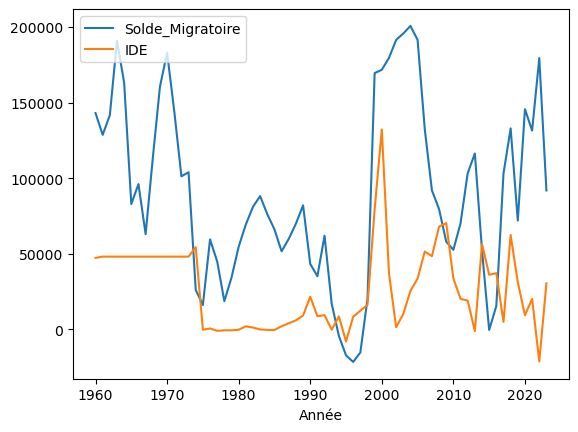

In [20]:
df_grand.plot(x="Année")

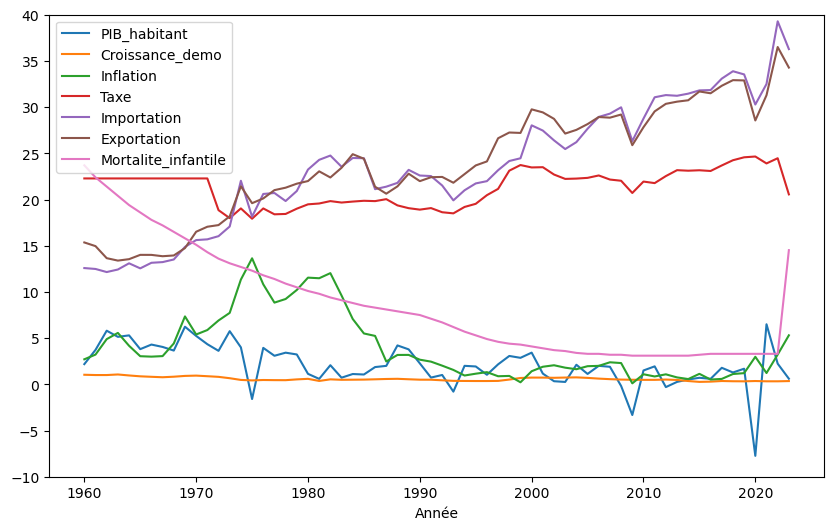

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

df.iloc[:, :8].plot(x= 'Année', ax=ax)
ax.set_ylim(bottom=-10, top=40)
ax.set_yticks([-10, -5, 0, 5,10,15, 20,25,30,35, 40])
plt.show()

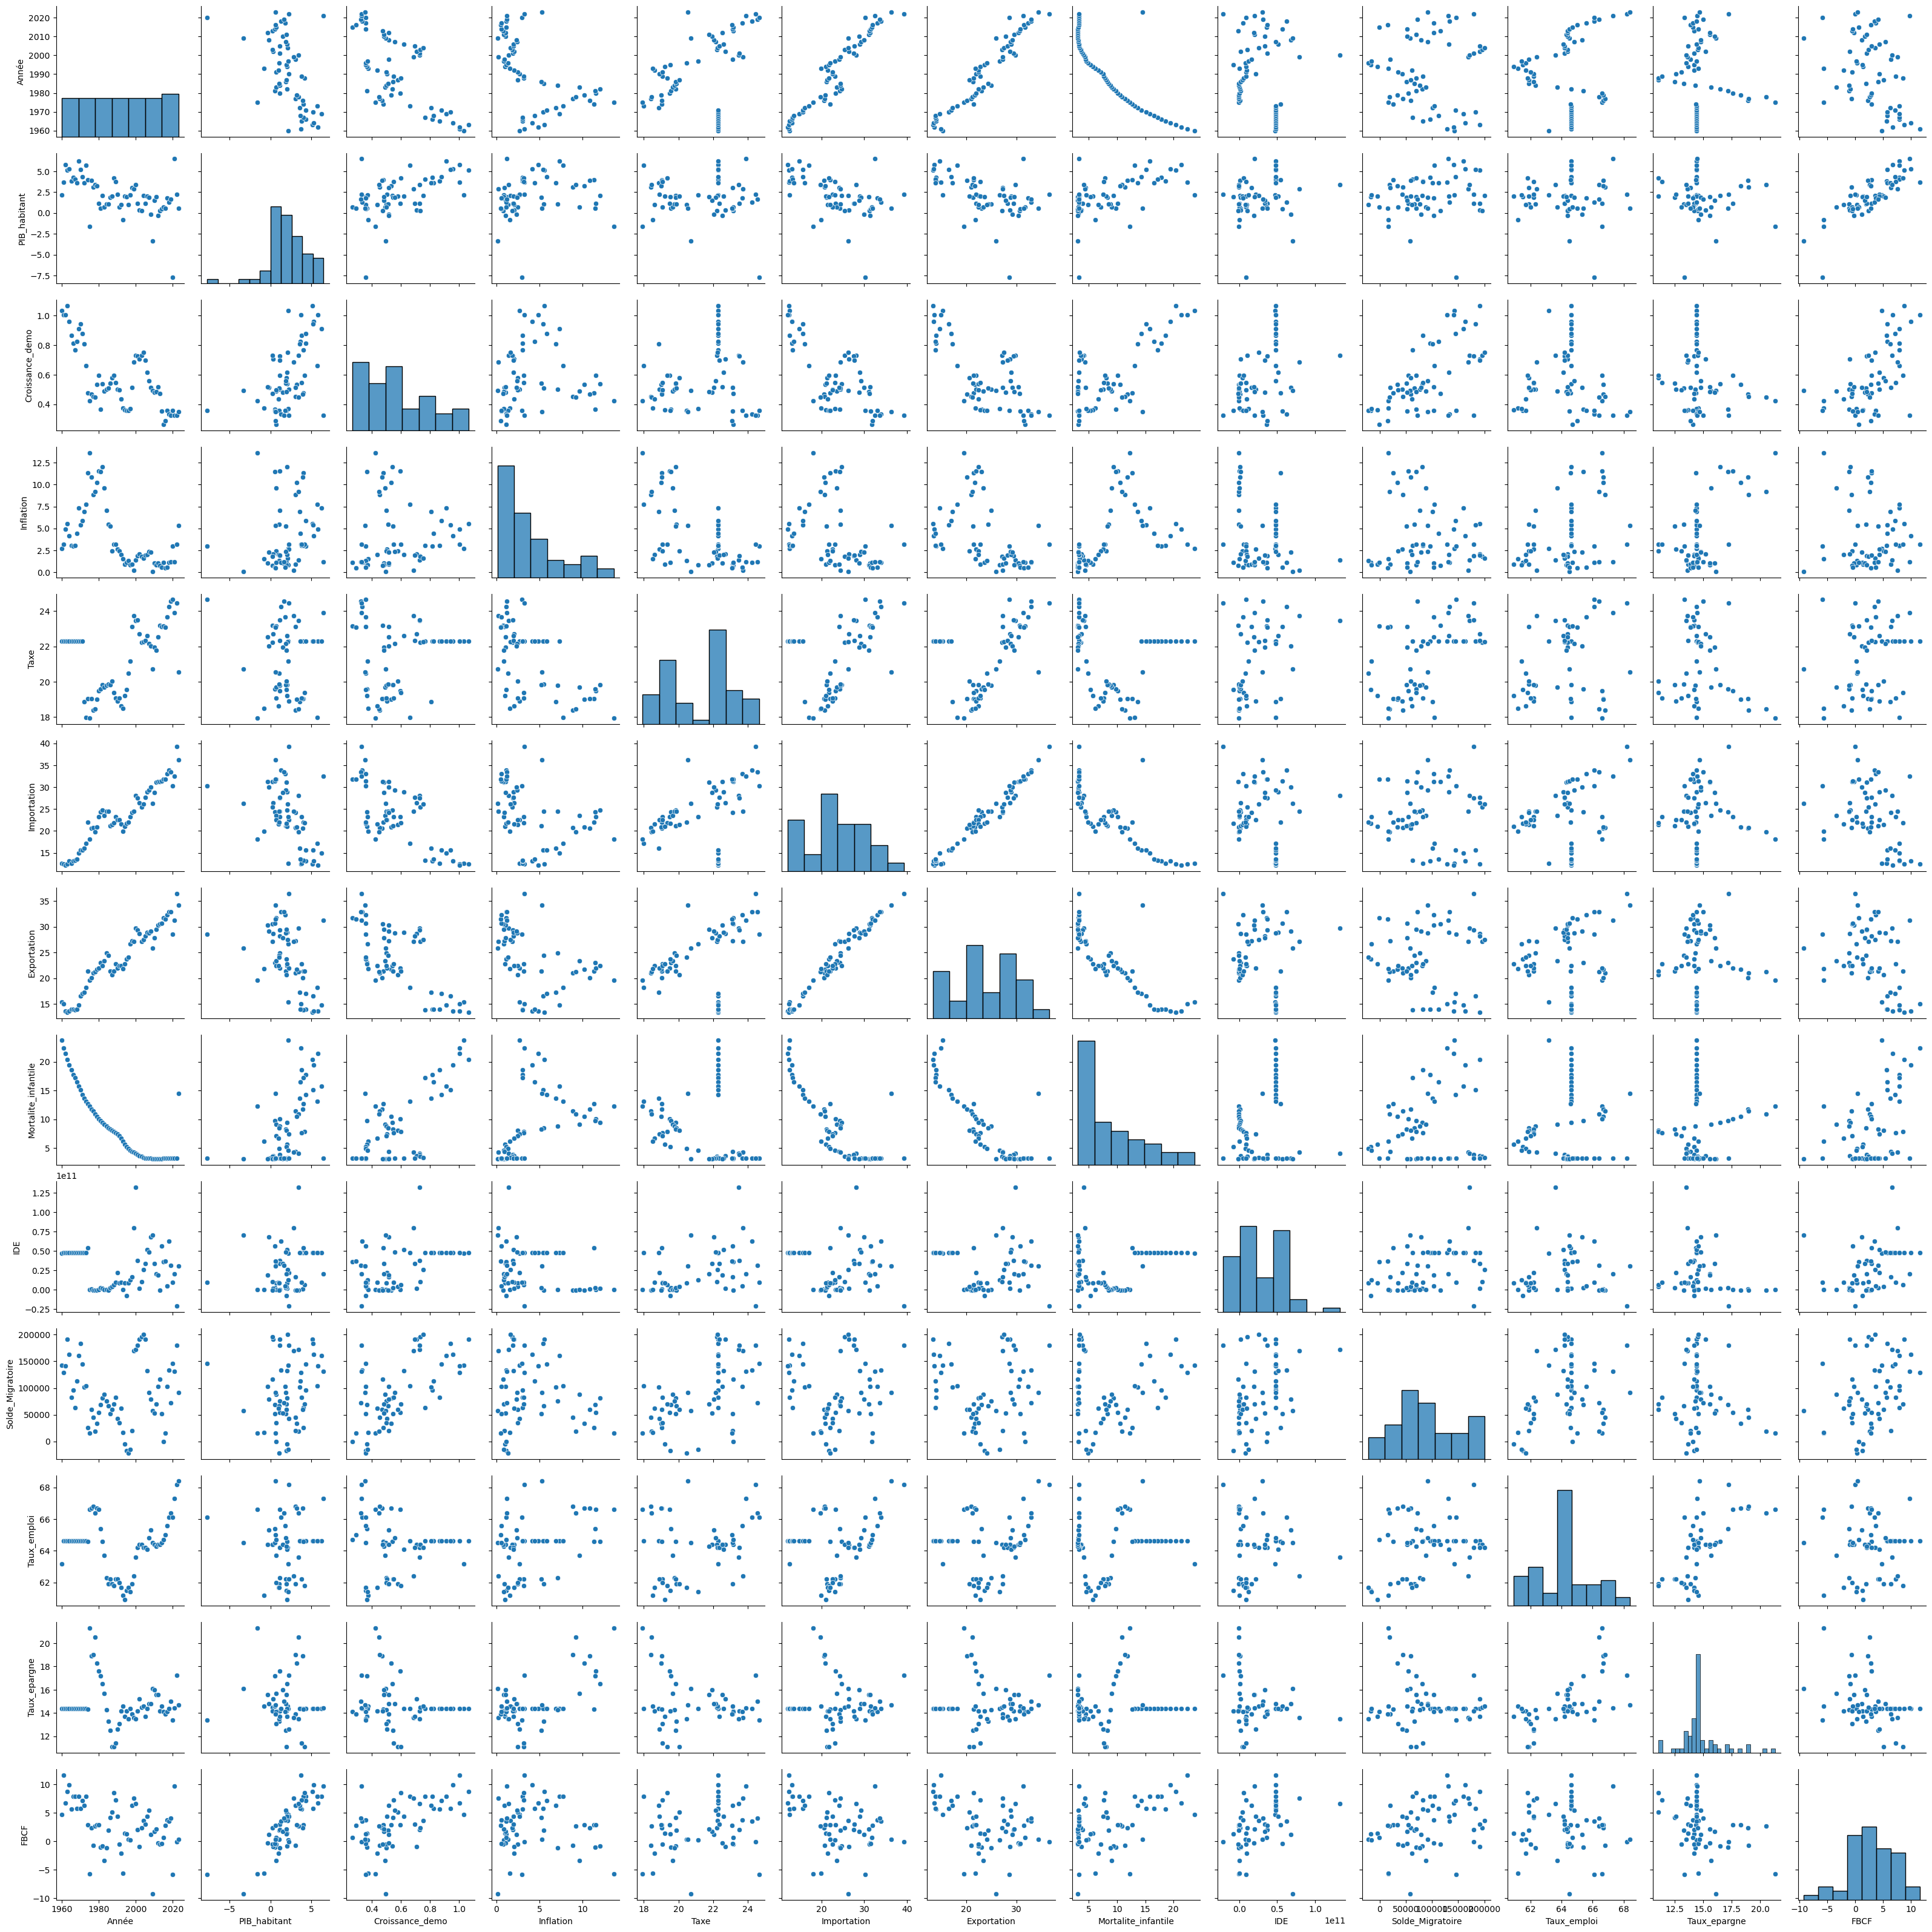

In [22]:
warnings.filterwarnings("ignore")
sns.pairplot(df)

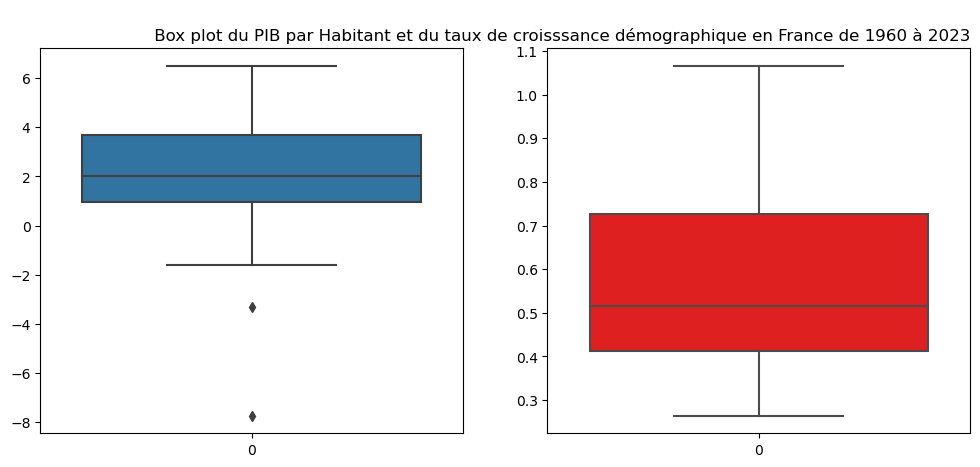

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(df["PIB_habitant"], ax = ax1)
sns.boxplot(df["Croissance_demo"], ax = ax2, color ='red')

plt.title("\n Box plot du PIB par Habitant et du taux de croisssance démographique en France de 1960 à 2023", loc= "right",)
plt.show()

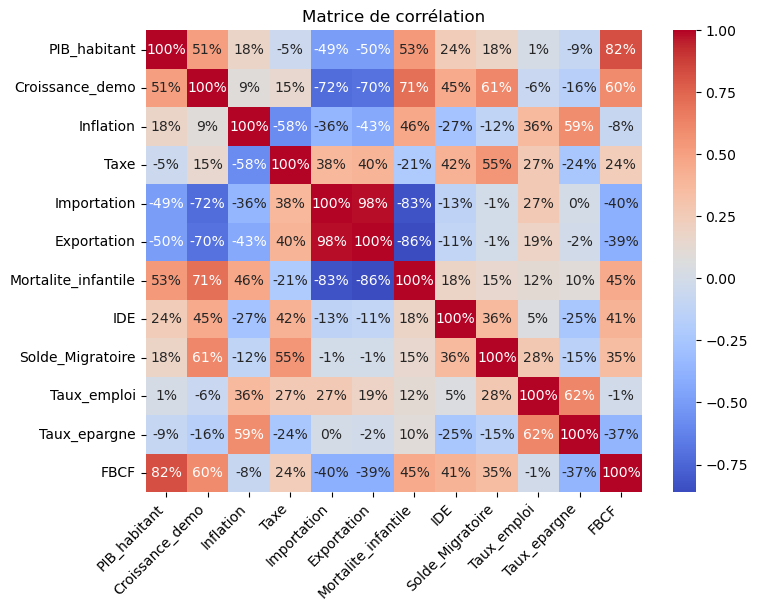

In [24]:
matrice_core = df.select_dtypes(include=np.number).iloc[:,1:].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_core, annot=True, cmap='coolwarm', fmt=".0%",
            xticklabels=1, yticklabels=1).set_xticklabels(matrice_core.columns, rotation=45, ha='right', fontsize=10)

plt.title("Matrice de corrélation")
plt.show()

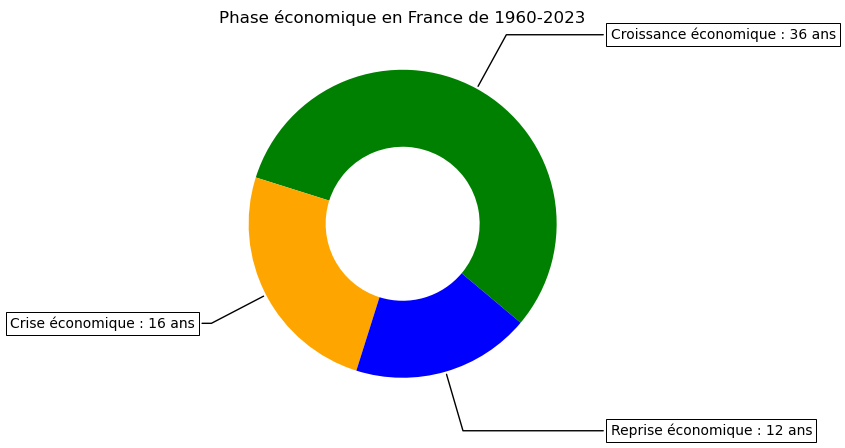

In [25]:
# code extrait de la documentation de Matplotlib et adapté à nos données

fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(aspect="equal"))

recipe = ["Croissance économique : 36 ans",
          "Crise économique : 16 ans",
          "Reprise économique : 12 ans"]

data = df["Phase_economique"].value_counts()

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, colors=["green","orange","blue"])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Phase économique en France de 1960-2023")

plt.show()

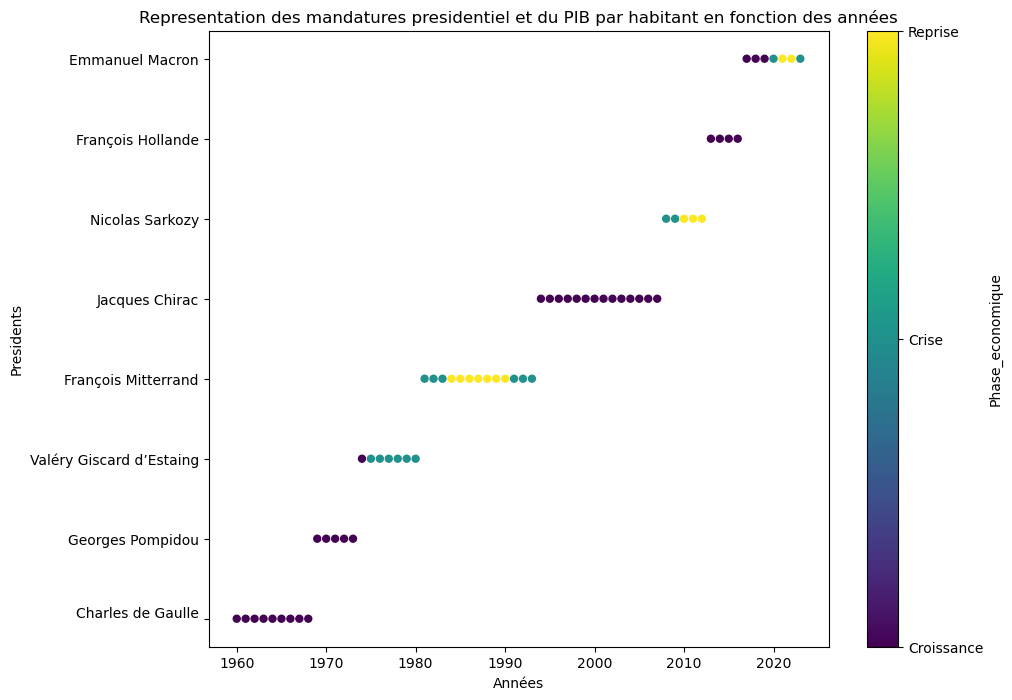

In [26]:
Annee = df["Année"]
PIB_hbt = df["PIB_habitant"]
Periode_politique = df["Periode_politique"]
phases_eco = df["Phase_economique"]
solde_migratoire = df["Solde_Migratoire"]
croissance_demo = df["Croissance_demo"]

phase_mapping = {'Croissance': 0, 'Crise': 1, 'Reprise': 2}

phases_eco_numeric = phases_eco.map(phase_mapping)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(Annee, Periode_politique, c=phases_eco_numeric, marker='.', linestyle='-', cmap='viridis', s=100)

plt.xlabel("Années")
plt.ylabel("Presidents")
plt.title("Representation des mandatures presidentiel et du PIB par habitant en fonction des années")

cbar = plt.colorbar(scatter)
cbar.set_label("Phase_economique")

cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Croissance', 'Crise', 'Reprise'])

plt.show()

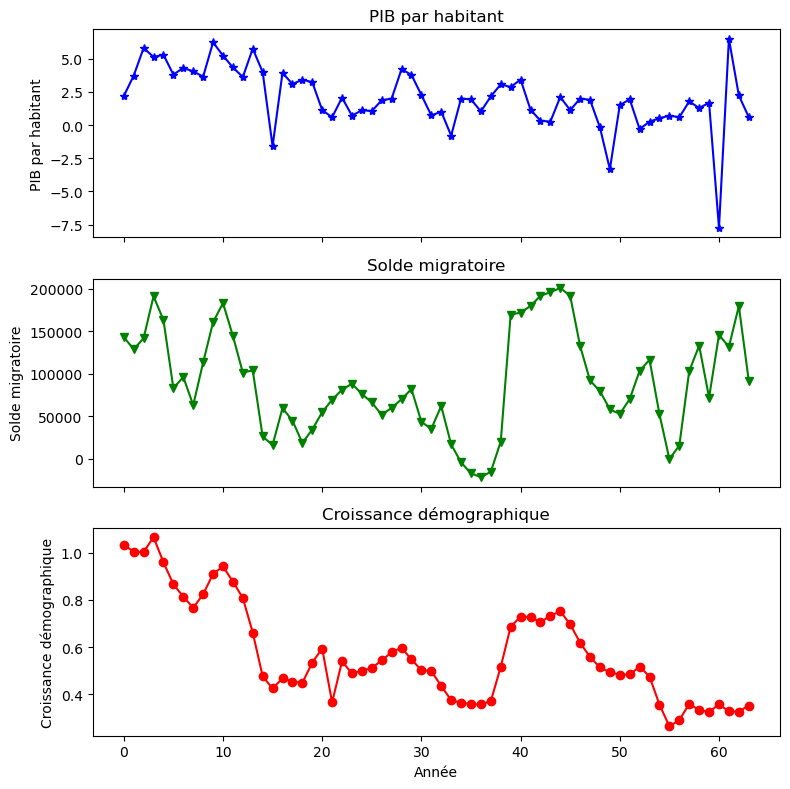

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(8,8), sharex=True)

axes[0].plot(df.index, df['PIB_habitant'], marker='*', linestyle='-', color='blue')
axes[0].set_title("PIB par habitant")
axes[0].set_ylabel("PIB par habitant")

axes[1].plot(df.index, df['Solde_Migratoire'], marker='v', linestyle='-', color='green')
axes[1].set_title("Solde migratoire")
axes[1].set_ylabel("Solde migratoire")

axes[2].plot(df.index, df['Croissance_demo'], marker='o', linestyle='-', color='red')
axes[2].set_title("Croissance démographique")
axes[2].set_ylabel("Croissance démographique")
axes[2].set_xlabel("Année")

plt.tight_layout()
plt.show()

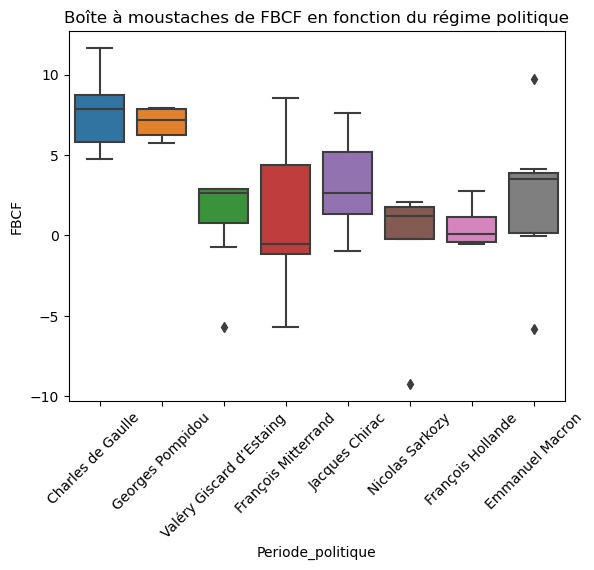

In [28]:
sns.boxplot(x="Periode_politique", y="FBCF",data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches de FBCF en fonction du régime politique')
plt.show()

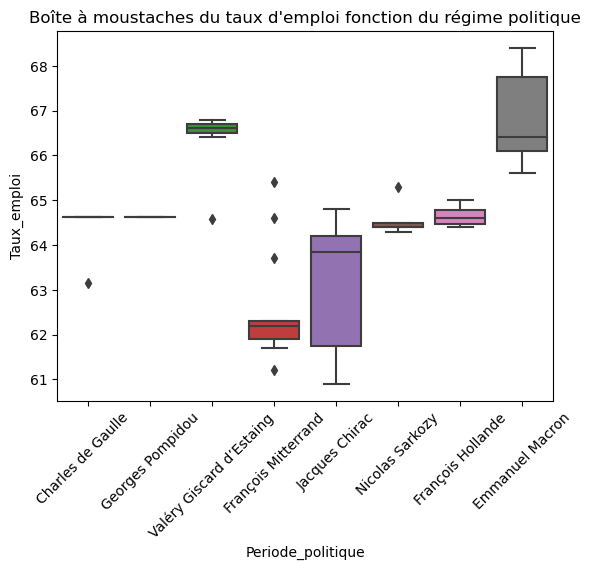

In [29]:
sns.boxplot(x="Periode_politique", y="Taux_emploi",data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches du taux d\'emploi fonction du régime politique')
plt.show()

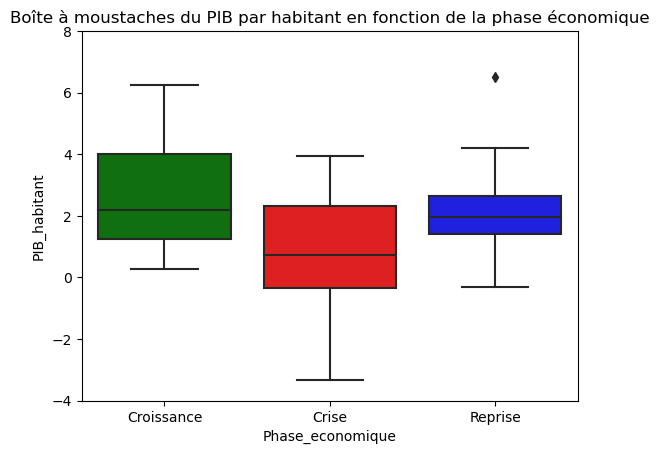

In [30]:
warnings.filterwarnings("ignore")

sns.boxplot(x="Phase_economique", y="PIB_habitant", palette =["green","red","blue"], data=df)
plt.ylim(bottom = -4, top = 8)
plt.title('Boîte à moustaches du PIB par habitant en fonction de la phase économique')
plt.show()

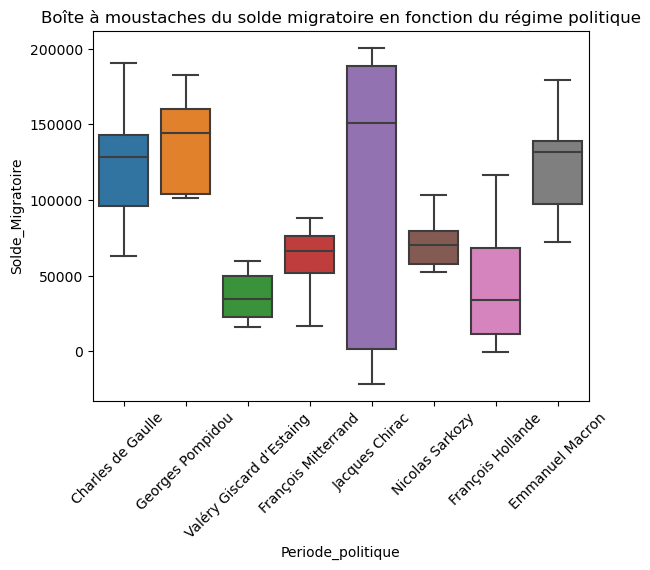

In [31]:
sns.boxplot(x="Periode_politique", y="Solde_Migratoire",data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches du solde migratoire en fonction du régime politique')
plt.show()

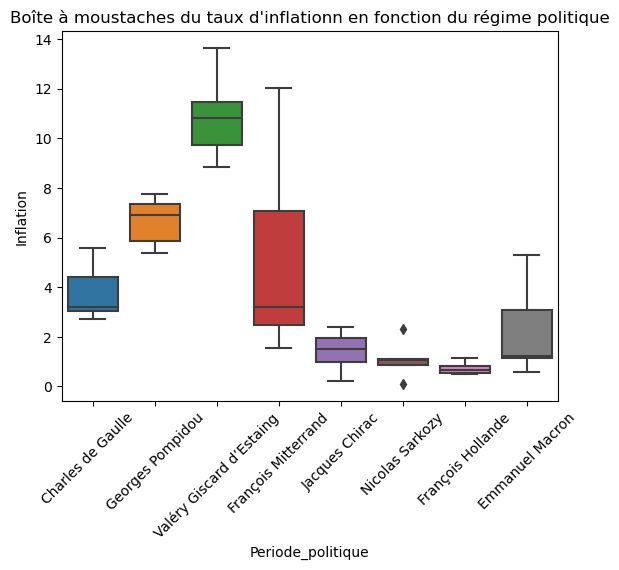

In [32]:
sns.boxplot(x="Periode_politique", y="Inflation",data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches du taux d\'inflationn en fonction du régime politique')
plt.show()

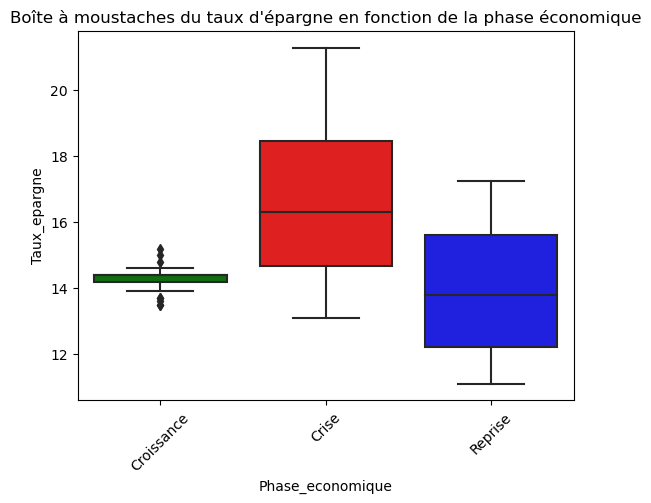

In [33]:
warnings.filterwarnings("ignore")

sns.boxplot(x="Phase_economique", y="Taux_epargne",palette =["green","red","blue"],data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches du taux d\'épargne en fonction de la phase économique')
plt.show()

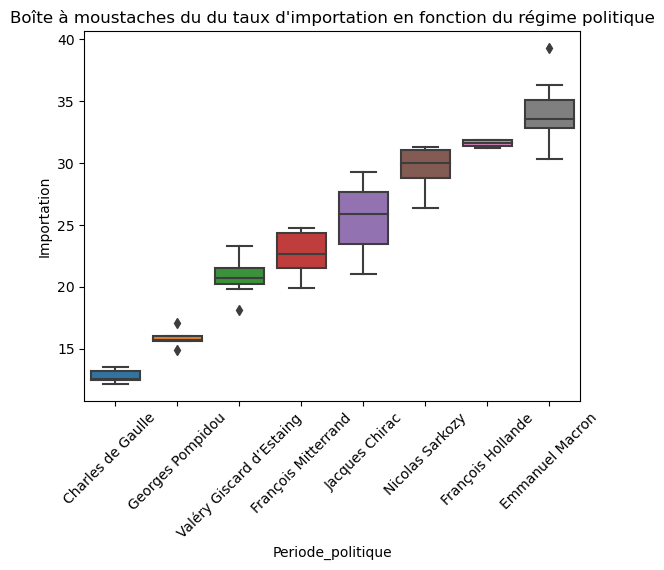

In [34]:
sns.boxplot(x="Periode_politique", y="Importation",data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches du du taux d\'importation en fonction du régime politique')
plt.show()

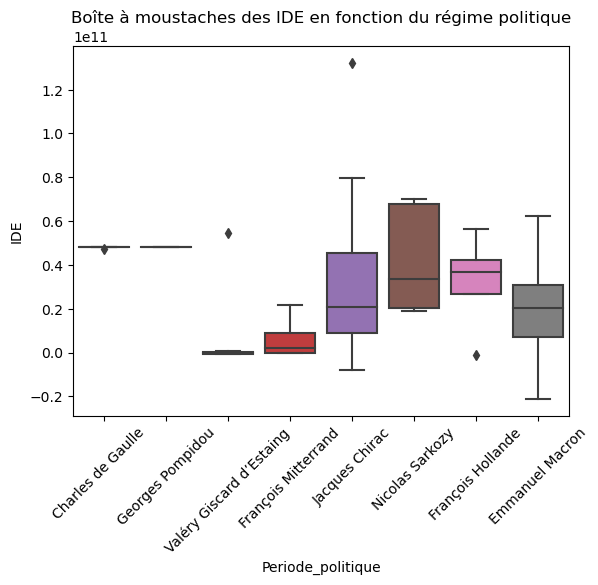

In [35]:
sns.boxplot(x="Periode_politique", y="IDE",data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches des IDE en fonction du régime politique')
plt.show()

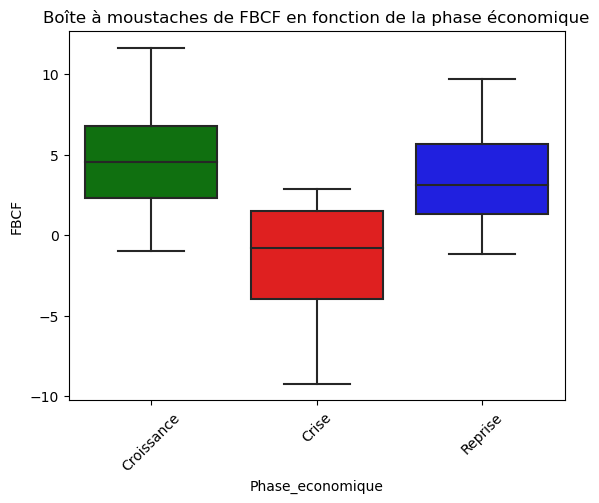

In [36]:
warnings.filterwarnings("ignore")

sns.boxplot(x="Phase_economique", y="FBCF",palette =["green","red","blue"],data=df)
plt.xticks(rotation=45)
plt.title('Boîte à moustaches de FBCF en fonction de la phase économique')
plt.show()

# MODELE DE REGRESSION LINEAIRE
On vas dans cette partie mettre en place un modèle de regression pour voir l'impact de chaque variable sur la croissance économique en France.
- Produire un modèle linéaire qui permettre d'expliquer les déterminant de la croissance économique et dans quel sens ils agissent.
- étant données que nous souhaitons connaitre l'impact de la croissance démographique sur la croissance éconimique durant cette période nos variables d'intéret sont :
    - **Y = PIB_Habitant**
    - **X = Croissance_demo**
    - Les autres variables servent de controle.

In [37]:
# Modèle de régression linéaire
model_1 = smf.ols(formula=
'''PIB_habitant ~ Croissance_demo + Inflation + Importation + Exportation + FBCF +
  Taux_epargne + Taux_emploi + Mortalite_infantile+ IDE +Taxe+Solde_Migratoire + Taxe''',
                data=df).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:           PIB_habitant   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     18.64
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.38e-14
Time:                        11:19:24   Log-Likelihood:                -92.274
No. Observations:                  64   AIC:                             208.5
Df Residuals:                      52   BIC:                             234.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              25.0688    

In [38]:
# Tests sur les résidus

residus_1 = model_1.resid

print(f" \nTest de normalité de Shapiro-Wilk :\n {shapiro(residus_1)}")
print(f" \nTest de normalité de Kolmogorov-Smirnov :\n {kstest(residus_1, 'norm')}\n")

 
Test de normalité de Shapiro-Wilk :
 ShapiroResult(statistic=0.956537663936615, pvalue=0.024295726791024208)
 
Test de normalité de Kolmogorov-Smirnov :
 KstestResult(statistic=0.0663481368012615, pvalue=0.9229941491988232, statistic_location=-0.34985666086208056, statistic_sign=-1)



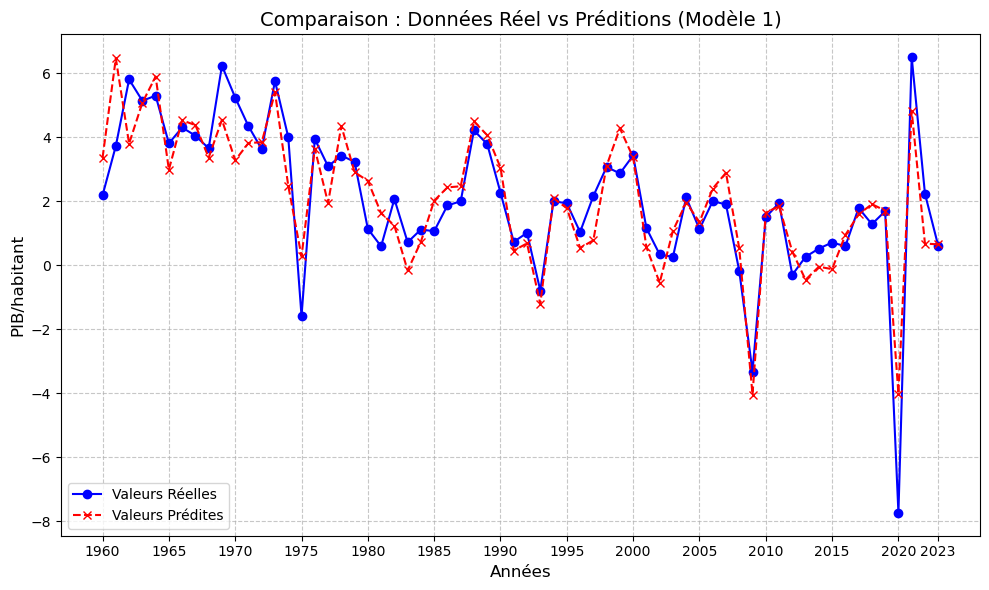

In [39]:
# Visualition des écart entre valeur réelles et valeurs prédites par le model 1

predictions_1 = model_1.predict()

plt.figure(figsize=(10, 6))

plt.plot(df["Année"], df["PIB_habitant"], 'b-', label='Valeurs Réelles', marker='o')
plt.plot(df["Année"], predictions_1, 'r--', label='Valeurs Prédites', marker='x')

xticks_years = list(np.arange(1960, 2024, 5)) + [2023]
plt.xticks(xticks_years)

plt.title("Comparaison : Données Réel vs Préditions (Modèle 1)", fontsize=14)
plt.xlabel("Années", fontsize=12)
plt.ylabel("PIB/habitant", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [40]:
# deuxième modèle de régression linéaire
# Dans ce modèle nous rétirons les variables non significatives du modèle 1

model_2 = smf.ols(formula=
'''PIB_habitant ~ Croissance_demo + Inflation + FBCF +
  Taux_epargne + Taux_emploi + Mortalite_infantile+ Taxe+Solde_Migratoire + Taxe''',
                  data=df).fit()

print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           PIB_habitant   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     26.58
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.78e-16
Time:                        11:19:24   Log-Likelihood:                -92.771
No. Observations:                  64   AIC:                             203.5
Df Residuals:                      55   BIC:                             223.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              19.5047    

In [41]:
residus_2 = model_2.resid

print(f" \nTest de normalité de Shapiro-Wilk :\n {shapiro(residus_2)}")
print(f" \nTest de normalité de Kolmogorov-Smirnov :\n {kstest(residus_2, 'norm')}\n")

 
Test de normalité de Shapiro-Wilk :
 ShapiroResult(statistic=0.9451900124549866, pvalue=0.006679691839963198)
 
Test de normalité de Kolmogorov-Smirnov :
 KstestResult(statistic=0.08564567970266057, pvalue=0.7033449547542219, statistic_location=-0.6510079431425897, statistic_sign=-1)



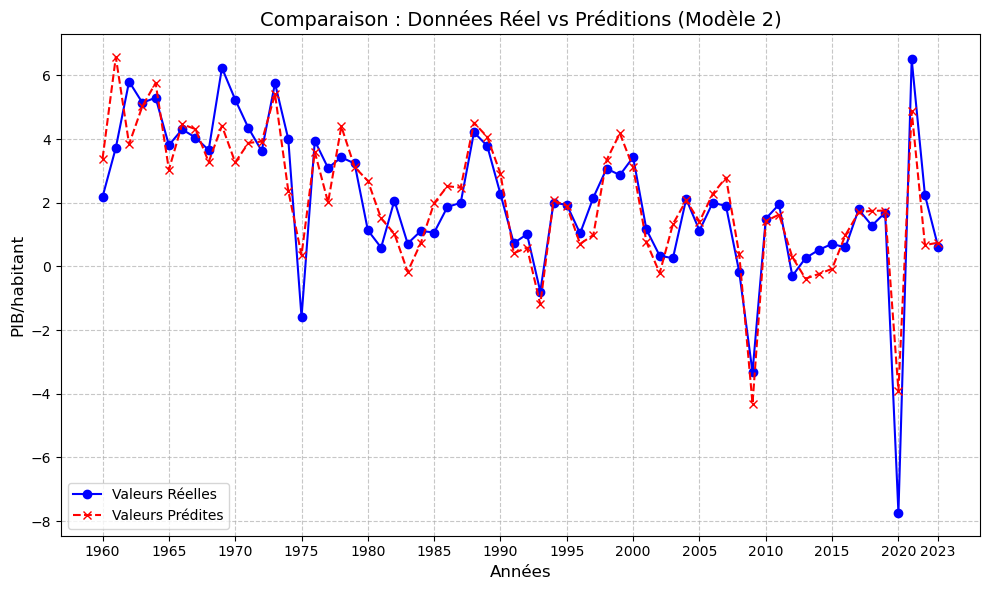

In [42]:
# Visualition des écart entre valeur réelles et valeurs prédites du modèle 2

xticks_years = np.arange(1960, 2026, 5)

# Générer les prédictions du modèle
predictions_2 = model_2.predict()

# Créer le graphique
plt.figure(figsize=(10, 6))

# Tracer les données réelles et prédites
plt.plot(df["Année"], df["PIB_habitant"], 'b-', label='Valeurs Réelles', marker='o')
plt.plot(df["Année"], predictions_2, 'r--', label='Valeurs Prédites', marker='x')

xticks_years = list(np.arange(1960, 2024, 5)) + [2023]
plt.xticks(xticks_years)

plt.title("Comparaison : Données Réel vs Préditions (Modèle 2)", fontsize=14)
plt.xlabel("Années", fontsize=12)
plt.ylabel("PIB/habitant", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [43]:
# Troisième modèle de régression linéaire
# Dans ce modèle nous rétirons les variables non significatives du model_2

model_3 = smf.ols(formula=
'''PIB_habitant ~ Croissance_demo + FBCF +
  Taux_epargne + Taux_emploi + Taxe+Solde_Migratoire + Taxe''',
                  data=df).fit()

residus_3 = model_3.resid

print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:           PIB_habitant   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     34.53
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.94e-17
Time:                        11:19:25   Log-Likelihood:                -94.331
No. Observations:                  64   AIC:                             202.7
Df Residuals:                      57   BIC:                             217.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.6118      7.559  

In [44]:
residus_3 = model_3.resid

print(f" \nTest de normalité de Shapiro-Wilk :\n {shapiro(residus_3)}")
print(f" \nTest de normalité de Kolmogorov-Smirnov :\n {kstest(residus_3, 'norm')}\n")


 
Test de normalité de Shapiro-Wilk :
 ShapiroResult(statistic=0.9651428461074829, pvalue=0.06748194247484207)
 
Test de normalité de Kolmogorov-Smirnov :
 KstestResult(statistic=0.09071542491593043, pvalue=0.6348878271412901, statistic_location=-0.7344396155704089, statistic_sign=-1)



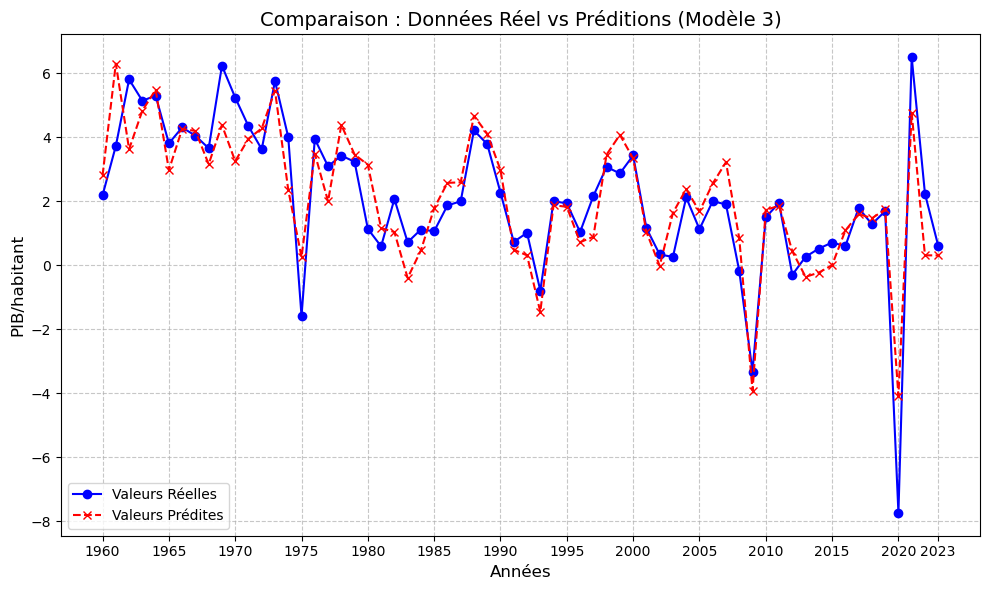

In [45]:
# Visualition des écarts entre valeurs réelles et valeurs prédites du modèle 3

xticks_years = np.arange(1960, 2026, 5)

# Générer les prédictions du modèle
predictions_3 = model_3.predict()

# Créer le graphique
plt.figure(figsize=(10, 6))

# Tracer les données réelles et prédites
plt.plot(df["Année"], df["PIB_habitant"], 'b-', label='Valeurs Réelles', marker='o')
plt.plot(df["Année"], predictions_3, 'r--', label='Valeurs Prédites', marker='x')

xticks_years = list(np.arange(1960, 2024, 5)) + [2023]
plt.xticks(xticks_years)

plt.title("Comparaison : Données Réel vs Préditions (Modèle 3)", fontsize=14)
plt.xlabel("Années", fontsize=12)
plt.ylabel("PIB/habitant", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### BILAN DES MODELES

#### Model 1 :
- ✅ Significativité Globale : Prob (F-statistic) < 5%
- ✅ R² ajusté : 82%
- ✅ Résidus Normalement distribués : Kstest > 5% ; Shapiro > 5%
- ❌ Autocorrélation : Durbin-Watson = 2.29
- ❌ Multicolinéarité : Condition number = 2.58e+12


#### Model 2 :
- ✅ Significativité Globale : Prob (F-statistic) < 5%
- ✅ R² ajusté : 81%
- ✅ Résidus Normalement distribués : Kstest > 5% ; Shapiro > 5%
- ❌ Autocorrélation : Durbin-Watson = 2.27
- ❌ Multicolinéarité : Condition number = 7.33e+06


#### Model 3 :
- ✅ Significativité Globale : Prob (F-statistic) < 5%
- ✅ R² ajusté : 81%
- ✅ Résidus Normalement distribués : Kstest > 5% ; Shapiro < 5%
- ❌ Autocorrélation : Durbin-Watson = 2.13
- ❌ Multicolinéarité : Condition number = 6.56e+06

Comme nous pouvons le constaté nos trois modèles ont aussi bien des points forts que des points moins robustes. Globalement ils sont tout significatifs. Ils expliquent tous à plus de 80% la variance du **PIB par Habitant** en France
les problèmes de multicolinéarités et d'autocorrélation peuvent remettre enc ause la robustesse de nos modèles d'estimation.

  - D'après le critèe de **Parcimonie** on choisi le *modèle 3* comme modèle final d'autant plus que les estimateurs sont statistiquement significatifs donc des determinant direct(Non exhaustives) de la croissance économique en France. Meme si le modèle 1 semble également très intérressant.

# MODELE DE SERIE TEMPORELLE

Une première tentative de résolution de notre problématique par une régression linéaire nous a conduit à des resultat peu concluant et un modèle de régression très corrélé violant ainsi les hypothèses de base des MCO.

C'est pas suprenant si on regarde la nature de nos variables économiques elles sont très souvent corrélé, l'une peut causer directement ou inderectement l'autre.

On décide donc de mettre en place un modèle de Série temporelle d'autant plus
que nos données sont des données chronologiques.

Les modèles de série Temporelles sont plus adapté à ce type de donné ils sont moins sensible à la multicolinéarité. Ils sont très robuste et prennent en compte le choc et cycles économiques.

La période 1960–2023 couvre de nombreux cycles économiques, crises et réformes politiques. les série temporelle s’adaptent donc à ces changements de dynamique.

- Nous allons utiliser un modèle **SARIMAX**, qui lui permet de modéliser une variable en prenant en compte les valeur et les erreur passées de cette variable mais également ajouter au modèle des variable exogène(celle du modèle 3).
- Variable d'interet : **Y = PIB/habitant**
- Variables exogènes : **X (Croissance_démographique, FBCF, Taxe, Solde_Migratoire,Taux_eparge, taux_emploie)**

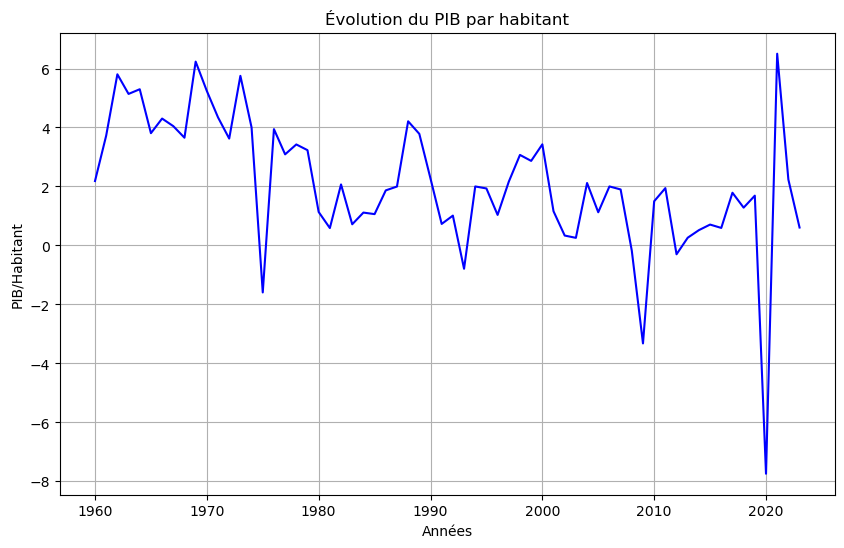

In [47]:
# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(df["Année"], df["PIB_habitant"], color='blue')
plt.title('Évolution du PIB par habitant')
plt.xlabel('Années')
plt.ylabel('PIB/Habitant')
plt.grid(True)
plt.show()

In [48]:
df_copy = df.copy()


df_copy["Année"] = pd.to_datetime(df_copy["Année"], format="%Y")
df_copy.set_index("Année", inplace=True)

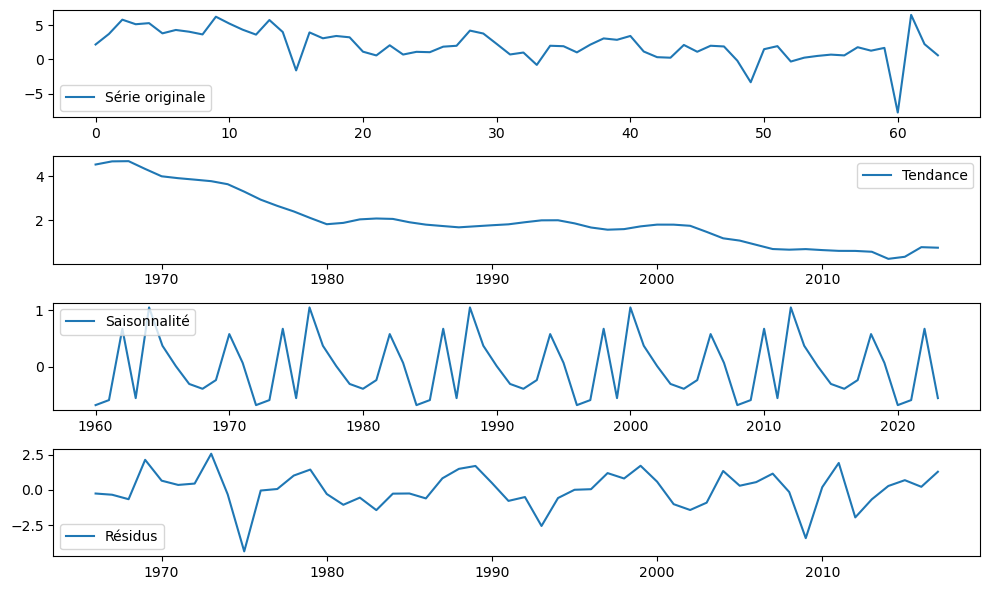

In [73]:
# Décomposition saisonnière de notre série

decomposition = seasonal_decompose(
    df_copy["PIB_habitant"],
    model="additive",
    period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))

plt.subplot(411)
plt.plot(df['PIB_habitant'], label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

### la saisonnalité et les résidus issus de la décomposition saisonnière oscillent on évoluent de manière constante au tour le valeur zéro.

In [75]:
result = adfuller(df['PIB_habitant'])

table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']]

print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -5.987919227780676        |
| P-valeur       | 1.7738924577250238e-07    |
| Conclusion     | La série est stationnaire |


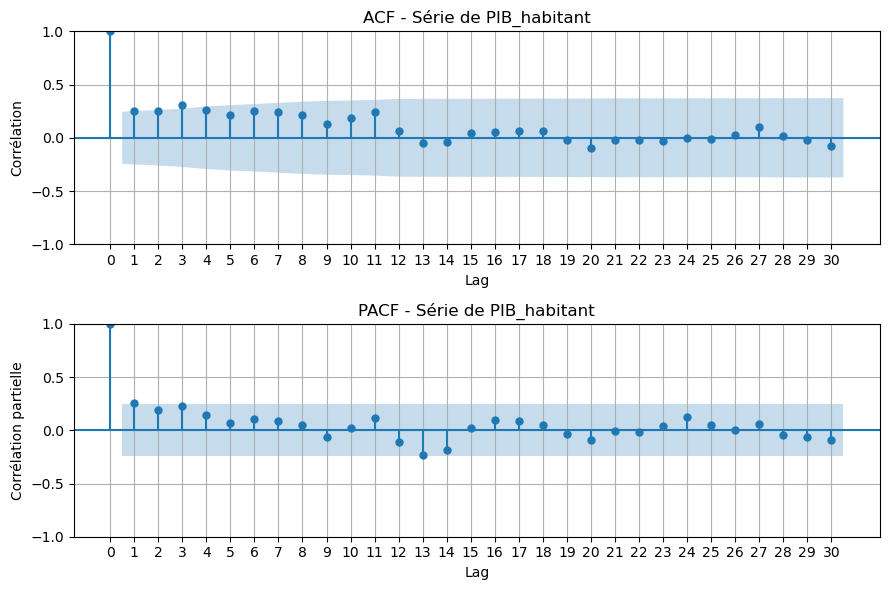

In [76]:
# Graphique des autocorrélogramme

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

# Tracer l'ACF
plot_acf(df['PIB_habitant'], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Série de PIB_habitant')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(df['PIB_habitant'], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Série de PIB_habitant')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

ax2.set_xticks(np.arange(0, 31, 1))

plt.tight_layout()
plt.show()

- On observe sur le graphiquede l'ACF un pic significatif
- On peutapercevoirtrois pics significatifs qui sortent légèrement de la bandedu PACF
- Modèleprobable : SARIMAX(1,0,3)

In [52]:
'''
séparation de la base en données d'entrainement et données de test
notre échantillon étant de petite taille on fera :
- on rétien uniquement les variables du modèle 3 de régression linéaire
- train  = 79% (50 observations)
- test = 21% (14 observations)
'''

data = df_copy[["PIB_habitant", "Croissance_demo","FBCF","Taux_epargne", "Taux_emploi", "Taxe","Solde_Migratoire"]]
train = data.iloc[:50,:]
test = data.iloc[50:,:]

In [53]:
display(train.head(5))
display(train.tail(5))

display(test.head(5))
display(test.tail(5))

,PIB_habitant,Croissance_demo,FBCF,Taux_epargne,Taux_emploi,Taxe,Solde_Migratoire
Année,,,,,,,
1960-01-01,2.184687,1.034469,4.749147,14.4,63.16,22.281556,143032
1961-01-01,3.725257,1.004280,11.667663,14.4,64.62,22.281556,128618
1962-01-01,5.803779,1.003536,6.693463,14.4,64.62,22.281556,141634
1963-01-01,5.138223,1.066209,8.740709,14.4,64.62,22.281556,190925
1964-01-01,5.297171,0.959388,9.961181,14.4,64.62,22.281556,163039


,PIB_habitant,Croissance_demo,FBCF,Taux_epargne,Taux_emploi,Taxe,Solde_Migratoire
Année,,,,,,,
2005-01-01,1.125354,0.696339,2.967110,13.7,64.2,22.344287,191417
2006-01-01,2.001311,0.618226,4.374152,14.4,64.1,22.603862,132512
2007-01-01,1.898567,0.558021,5.461605,14.8,64.8,22.161734,91973
2008-01-01,-0.178411,0.513351,1.206220,14.8,65.3,22.031561,79528
2009-01-01,-3.322124,0.492976,-9.228881,16.1,64.5,20.707649,58032


,PIB_habitant,Croissance_demo,FBCF,Taux_epargne,Taux_emploi,Taxe,Solde_Migratoire
Année,,,,,,,
2010-01-01,1.498725,0.482667,1.762963,16.0,64.4,21.944014,52644
2011-01-01,1.944335,0.483715,2.100857,15.6,64.3,21.776538,70178
2012-01-01,-0.299599,0.516915,-0.251331,15.6,64.4,22.536321,103287
2013-01-01,0.262145,0.474848,-0.547380,14.2,64.4,23.176294,116297
2014-01-01,0.519384,0.355569,-0.396403,14.6,64.5,23.118742,52342


,PIB_habitant,Croissance_demo,FBCF,Taux_epargne,Taux_emploi,Taxe,Solde_Migratoire
Année,,,,,,,
2019-01-01,1.688708,0.324558,4.110082,15.00,66.4,24.569375,71972
2020-01-01,-7.740568,0.356902,-5.829109,13.38,66.1,24.654612,145593
2021-01-01,6.501552,0.326992,9.734361,14.46,67.3,23.906122,131465
2022-01-01,2.235989,0.326319,-0.047778,17.24,68.2,24.468609,179377
2023-01-01,0.607649,0.351892,0.389681,14.68,68.4,20.557075,91862


In [54]:
print(train.shape)
print(test.shape)

(50, 7)
(14, 7)


In [55]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train["Croissance_demo"]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=1, q=0), AIC = 187.61


In [56]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["Croissance_demo","FBCF"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=3, q=2), AIC = 138.49


In [57]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["Croissance_demo","FBCF","Taux_epargne"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=1, q=3), AIC = 138.37


In [58]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["Croissance_demo","FBCF","Taux_epargne", "Taux_emploi"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=1, q=3), AIC = 140.05


In [59]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["Croissance_demo","FBCF","Taux_epargne", "Taux_emploi","Taxe"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=0, q=1), AIC = 147.42


In [60]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["Croissance_demo","FBCF","Taux_epargne", "Taux_emploi", "Taxe","Solde_Migratoire"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=1, q=0), AIC = 149.87


In [61]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["FBCF","Taux_epargne"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=1, q=3), AIC = 136.37


In [62]:
warnings.filterwarnings("ignore")

'''
- La série étant stationnaire sans différenciation : i = 0
- Nous utilisons cette boucle  pour derterminer automatiquement p et q
- On augmente progressivement le nombre de variable expliquative pour voir
quelles variable permet à notre modèle de perdre un minimum d'information
- le modèle optimal est celui dont la valeur de AIC est minimale

 '''

exo = train[["Croissance_demo","FBCF","Taux_epargne"]]

p = q = range(0, 4)
best_aic = np.inf
best_order = None

for (p_val, q_val) in itertools.product(p, q):
    try:
        model = SARIMAX(train["PIB_habitant"], order=(p_val, 0, q_val), exog= exo)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p_val, 0, q_val)
    except:
        continue

if best_order is not None:
    print(f"Meilleur ordre ARMA : (p={best_order[0]}, q={best_order[2]}), AIC = {best_aic:.2f}")
else:
    print("Aucun modèle valide n'a pu être estimé.")

Meilleur ordre ARMA : (p=1, q=3), AIC = 138.37


### Les deux meilleures modèles ont pour paramètres :
 #### modèle 1 :
 - Ordre ARMA : (p=1, q=3)
 - Variables exogènes : X = ["Croissance_demo", "FBCF", "Taux_epargne"]
 - AIC = 135.33


 #### modèle 2 :
 - Ordre ARMA : (p=1, q=3)
 - Variables exogènes : X = ["FBCF", "Taux_epargne"]
 - ✅ AIC = 133.67

In [63]:
exo = train[["Croissance_demo","FBCF","Taux_epargne"]]

model1 = SARIMAX(train["PIB_habitant"], order=(1, 0, 3), exog= exo)

model1_fit = model1.fit()
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           PIB_habitant   No. Observations:                   50
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 -61.183
Date:                Thu, 24 Apr 2025   AIC                            138.365
Time:                        11:19:51   BIC                            153.661
Sample:                    01-01-1960   HQIC                           144.190
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Croissance_demo     0.0682      0.887      0.077      0.939      -1.669       1.806
FBCF                0.3182      0.030     10.720      0.000       0.260       0.376
Taux_epargne        0.0615      

In [64]:
exo = train[["FBCF","Taux_epargne"]]

model2 = SARIMAX(train["PIB_habitant"], order=(1, 0, 3), exog= exo)

model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           PIB_habitant   No. Observations:                   50
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 -61.186
Date:                Thu, 24 Apr 2025   AIC                            136.372
Time:                        11:19:51   BIC                            149.756
Sample:                    01-01-1960   HQIC                           141.469
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FBCF             0.3183      0.025     12.989      0.000       0.270       0.366
Taux_epargne     0.0612      0.035      1.741      0.082      -0.008       0.130
ar.L1            0.9313      0.070     13.32

#### Le modèle 2 : SARIMAX(1, 0, 3) & X = ["FBCF", "Taux_epargne"] est clairement meilleur que le premier car :
- Meilleurs critères d'information
- Résidus normalement distribués
- Résidus homoscédastiques.

##### Tout les coefficients estimés du modèle 2 sont statistiquement significatifs sauf le **ma.L2** on vas donc estimé un modèle sans ce paramètre puis comparer les deux modèles est choisir les plus robuste.

In [65]:
exo = train[["FBCF","Taux_epargne"]]

model2 = SARIMAX(train["PIB_habitant"], order=(1, 0, [1,3]), exog= exo)

model2_fit = model2.fit()
print(model2_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:              PIB_habitant   No. Observations:                   50
Model:             SARIMAX(1, 0, [1, 3])   Log Likelihood                 -61.777
Date:                   Thu, 24 Apr 2025   AIC                            135.554
Time:                           11:19:51   BIC                            147.026
Sample:                       01-01-1960   HQIC                           139.923
                            - 01-01-2009                                         
Covariance Type:                     opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FBCF             0.3223      0.023     13.886      0.000       0.277       0.368
Taux_epargne     0.0658      0.033      1.966      0.049       0.000       0.131
ar.L1            0.9

#### On retiens comme modèle définitif le SARIMAX(1,0,[1,3]) avec 'FBCF' et 'Taux_epargne' comme variables exogènes.

- Critère d'informations minimales : (AIC = 132) & (BIC = 144)
- Homoscédasticité : Prob(H) = 0.09 > 5%
- Résidus normalement distribués : Prob(JB) > 5%
- Tout les paramètre sont statistiquement significatifs *p-value* < 5%

Ce modèle sera par la suite entrainer et test avec nos données.

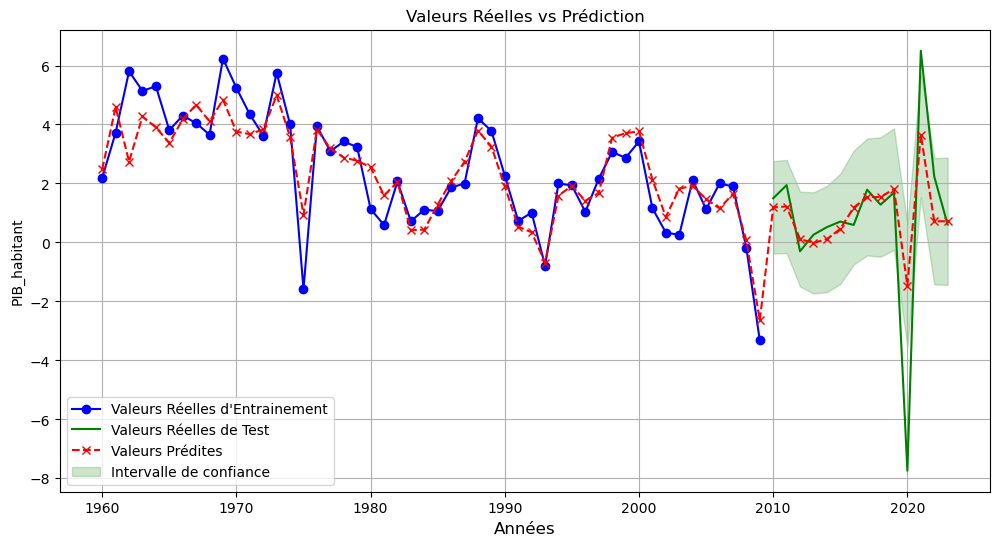

In [66]:
train_exo = train[["FBCF","Taux_epargne"]]
test_exo = test[["FBCF","Taux_epargne"]]


# Prédictions sur l'ensemble d'entraînement
train_pred_results = model2_fit.get_prediction(start=train.index[0], end=train.index[-1], exog = train_exo)
train_prediction = train_pred_results.predicted_mean
train_confint = train_pred_results.conf_int()

# Prédictions sur l'ensemble de test
test_pred_results = model2_fit.get_prediction(start=test.index[0], end=test.index[-1], exog = test_exo)
test_prediction = test_pred_results.predicted_mean
test_confint = test_pred_results.conf_int()

# Concaténer les prédictions
toutes_predictions = pd.concat([train_prediction, test_prediction])

# Tracer les observations et prédictions
plt.figure(figsize=(12, 6))
plt.plot(train['PIB_habitant'], 'b-', color='blue', label='Valeurs Réelles d\'Entrainement', marker='o')
plt.plot(test['PIB_habitant'], label='Valeurs Réelles de Test', color='green')
plt.plot(toutes_predictions, 'r--', color='red', label='Valeurs Prédites', marker='x')

# Intervalles de confiance
plt.fill_between(test_confint.index,
                 test_confint.iloc[:, 0], test_confint.iloc[:, 1],
                 color='green', alpha=0.2, label='Intervalle de confiance')
plt.xlabel("Années", fontsize=12)
plt.ylabel('PIB_habitant')
plt.title('Valeurs Réelles vs Prédiction')
plt.legend()
plt.grid(True)
plt.show()

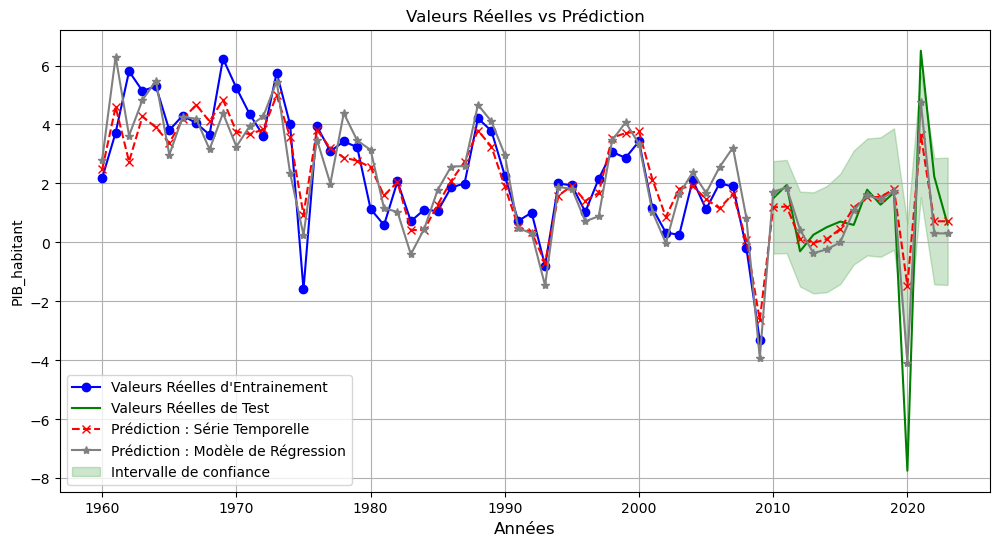

In [67]:
# Tracer les observations et prédictions
plt.figure(figsize=(12, 6))
plt.plot(train['PIB_habitant'], 'b-', color='blue', label='Valeurs Réelles d\'Entrainement', marker='o')
plt.plot(test['PIB_habitant'], label='Valeurs Réelles de Test', color='green')
plt.plot(toutes_predictions, 'r--', color='red', label='Prédiction : Série Temporelle', marker='x')
plt.plot(df_copy.index, predictions_3, 'bs-',color='gray', label='Prédiction : Modèle de Régression', marker='*')

plt.fill_between(test_confint.index,
                 test_confint.iloc[:, 0], test_confint.iloc[:, 1],
                 color='green', alpha=0.2, label='Intervalle de confiance')

plt.xlabel("Années", fontsize=12)
plt.ylabel('PIB_habitant')
plt.title('Valeurs Réelles vs Prédiction')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Calculer les mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['PIB_habitant'], train_prediction)
train_mse = mean_squared_error(train['PIB_habitant'], train_prediction)
train_rmse = mean_squared_error(train['PIB_habitant'], train_prediction)
train_r2 = r2_score(train['PIB_habitant'], train_prediction)

# Calculer les mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['PIB_habitant'], test_prediction)
test_mse = mean_squared_error(test['PIB_habitant'], test_prediction)
test_rmse = mean_squared_error(test['PIB_habitant'], test_prediction)
test_r2 = r2_score(test['PIB_habitant'], test_prediction)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]}).round(3)

print(performance_df)


  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                    0.646             1.025
1      MSE                    0.762             3.672
2     RMSE                    0.762             3.672
3       R²                    0.798             0.545


- Le modèle surapprendsur sur les données d'entrainement
- Léger problème d'overfiting
- Le modèle pourra etre amélirer avec d'autres techniques (Normalisation, Feature Engineerin, etc....)